# Image Reconstruction of Neutral Hydrogen Intensity Mapping

This script showcases the 21cm line emission functions in Karabo. We begin with a HI source catalog (produced from PINOCCHIO DM Halos and a DM-to-HI halo model-based conversion). We then pass this HI source catalog through OSKAR, to generate dirty images across different frequency channels.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from datetime import datetime, timedelta
from astropy.coordinates import EarthLocation, AltAz, ICRS
import astropy.units as u
from pathlib import Path

from karabo.simulation.sky_model import SkyModel, SkyPrefixMapping
from karabo.data.external_data import HISourcesSmallCatalogDownloadObject
from karabo.simulation.line_emission import (
    line_emission_pointing,
    plot_scatter_recon,
    gaussian_fwhm_meerkat,
    simple_gaussian_beam_correction,
    sky_slice,
)

%matplotlib inline

In [11]:
# Path to the HDF5 HI catalog file
survey = HISourcesSmallCatalogDownloadObject()
catalog_path = survey.get()

# Path used to store outputs from the pipeline
outpath = Path("results")

# Cut in degrees used when running simulation
cut = 3.0

The observation location should be compatible with the MeerKAT site. Also, the observation time and the coordinate has to be set. We need to pay attention that the sky model passes through the field of view during the observation! Therefore, we choose an observation time and calculate a corresponding possible phase center, which we choose to be the zenith at observation time.

In [13]:
# Observation specifications
# Observation location = MeerKAT location
MeerKAT_lon = "21d26m38.0s"  # Earth location
MeerKAT_lat = "-30d42m39.8s"  # deg. Corresponds to phase center dec.
meerkat_location = EarthLocation(lon=MeerKAT_lon, lat=MeerKAT_lat, height=1086.6 * u.m)

# Specify the desired observation time
t_obs = "2000-03-20 12:06:39"
observing_time = Time(t_obs)

# We find the phase center, which we define to be the zenith
# at the location of MeerKAT during the observation time
pointing = AltAz(
    alt=90 * u.deg, az=0 * u.deg, location=meerkat_location, obstime=observing_time
)
phase_center = pointing.transform_to(ICRS())
print("The phase center is at:", phase_center)

ra_deg = phase_center.ra.deg
dec_deg = phase_center.dec.deg

The phase center is at: <ICRS Coordinate: (ra, dec) in deg
    (21.44213503, -30.70729488)>


## Prepare the sky model

After configuring the observation specifications, we prepare the sky model. We load the HI source catalog, and filter out sources that are far from our phase center, based on the desired FOV of the observation.

In [14]:
# Load catalog from HDF5 file, including redshift information,
# and only keeping sources within a desired FOV
sky_pointing = SkyModel.get_sky_model_from_h5_to_xarray(catalog_path)

sky_pointing = sky_pointing.filter_by_radius_euclidean_flat_approximation(
    inner_radius_deg=0,
    outer_radius_deg=5,
    ra0_deg=ra_deg,
    dec0_deg=dec_deg,
)

Scatter plot of the diluted sky model in the FOV.

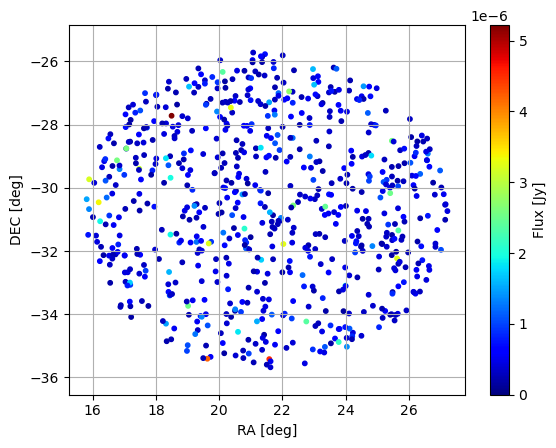

In [15]:
# We can visualize the filtered HI source objects on a scatter plot
sky_pointing.explore_sky(
    phase_center=(ra_deg, dec_deg),
    vmin=0,
    s=10,
    cmap="jet",
    cbar_label="Flux [Jy]",
    cfun=None,
    wcs_enabled=False,
    xlabel="RA [deg]",
    ylabel="DEC [deg]",
)

In [16]:
# Configure Dask for parallelization out of the box
from karabo.util.dask import DaskHandler

DaskHandler.n_threads_per_worker = 1

## Line emission simulation

We move forward with the 21cm line emission simulation.

The key feature of line emission is a 1-1 correspondence between observed frequency and source redshift. In fact, recall that $1+z = \frac{\lambda_{obs}}{\lambda_{emit}}$, where the emitting wavelength of HI is 21 cm = 0.21m and $\lambda = \frac{c}{f}$. Therefore $f_{obs} = \frac{c}{0.21(1+z)}$.

We perform the line emission across a series of _frequency channels_. This leads us to separate the source catalog into _redshift slices_. We produce dirty images for each frequency channel, and produce an additional summed image (stacked along the frequency axis).

In [17]:
# %%timeit

# Perform line emission simulation for the desired sky pointing
dirty_im, _, header_dirty, freq_mid_dirty = line_emission_pointing(
    outpath=outpath, sky=sky_pointing
)

The frequency channel starts at: 807809254.5689256 Hz
The bin sizes of the freq channel are: [10434974.93846536 10434974.93846524 10434974.93846524 10434974.93846536
 10434974.93846536 10434974.93846524 10434974.93846524 10434974.93846536
 10434974.93846536 10434974.93846524] Hz
Submitting 10 jobs to the cluster.
Dashboard link: http://148.187.57.184:8787/status
Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_147b6cbd-491c-4ea0-b46e-a2bef98bdd4d directory for data object storage.
Saved visibility to results/slice_9.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_259cefb1-ae59-4146-b81e-22d3de2c855d directory for data object storage.
Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_f5ff9bb6-f522-4caf-82c5-5cb5d98e1ba9 directory for data object storage.
Saved visibility to results/slice_2.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_17260f23-ac5a-458c-9c90-132a4ea19c95 directory for data object stor

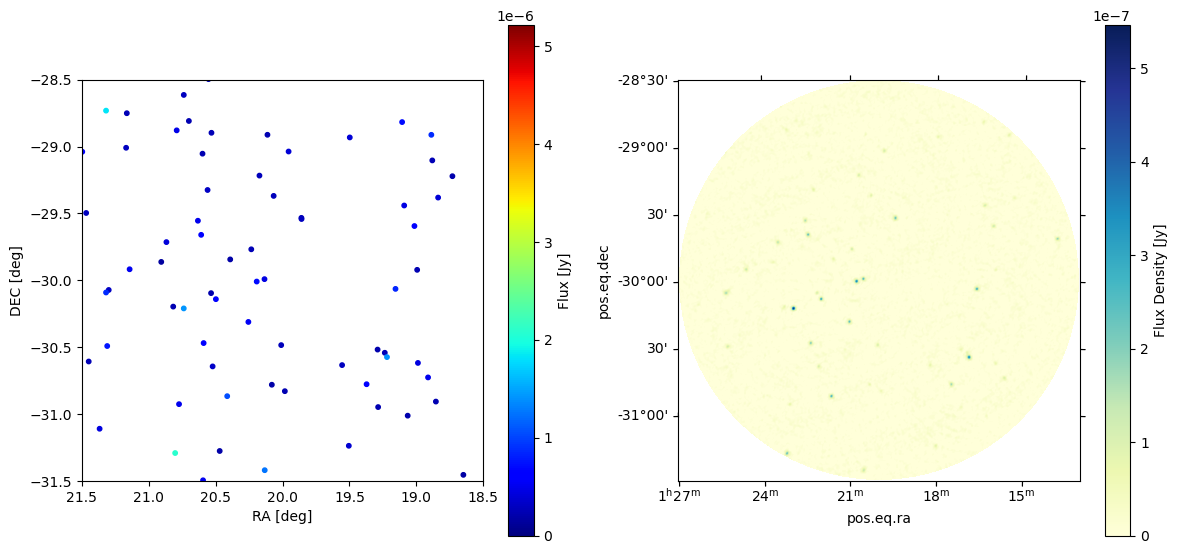

In [18]:
# Visualize the input HI source catalog (left side) and the resulting dirty image (right side)
plot_scatter_recon(
    sky_pointing,
    dirty_im,
    outpath / "test_line_emission.pdf",
    header_dirty,
    f_min=3 * 10**-26,
)

## Primary beam effects

The OSKAR simulation above assumes a Gaussian primary beam. We can therefore produce a correction for the beam, and apply this correction to the produced dirty images.

Calculate gaussian beam for primary beam correction...
Apply primary beam correction...


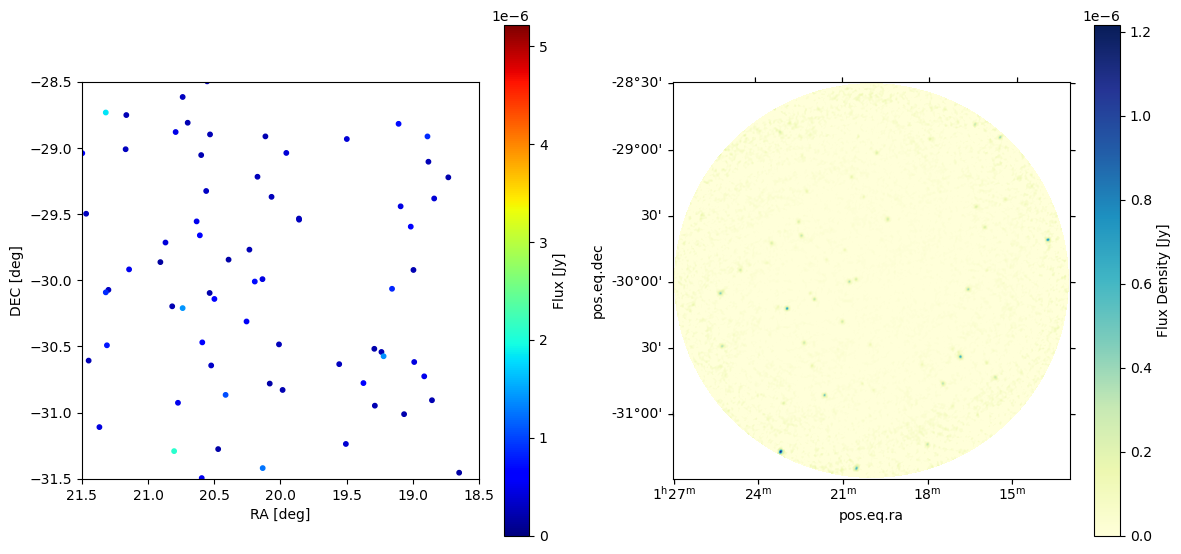

In [19]:
# Note that the Gaussian beam FWHM depends on the frequency channel being observed
gauss_fwhm = gaussian_fwhm_meerkat(freq_mid_dirty)

beam_corrected, _ = simple_gaussian_beam_correction(outpath, dirty_im, gauss_fwhm)

plot_scatter_recon(
    sky_pointing,
    beam_corrected,
    outpath / "test_line_emission_beamcorrected.pdf",
    header_dirty,
)

## Complex visibilities

The line emission pipeline results in complex visibilities files for the different frequency channels, which are automatically stored (e.g. `slice_0.vis`). Below we use these visibility files to showcase the UV plane coverage.

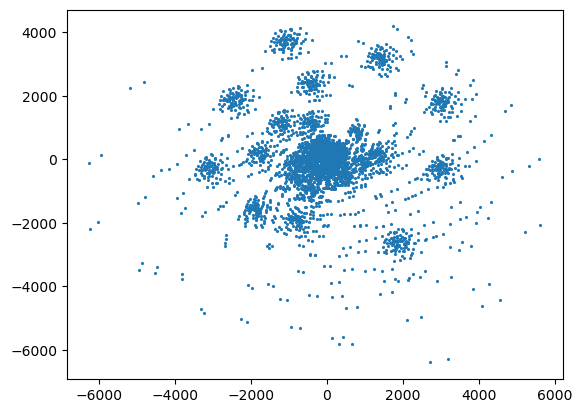

In [20]:
import oskar

(visHeader, visHandle) = oskar.VisHeader.read(str(outpath / "slice_0.vis"))
visBlock = oskar.VisBlock.create_from_header(visHeader)
for i in range(visHeader.num_blocks):
    visBlock.read(visHeader, visHandle, i)
uu = visBlock.baseline_uu_metres()
vv = visBlock.baseline_vv_metres()

plt.figure()
plt.scatter(uu, vv, s=2, marker="*")
plt.show()

# Visualize parallelization of the line emission simulation

For the parallelization, we use `dask`. In particular, we use the `dask.delayed()` and `dask.compute()` functionality.

In [21]:
from karabo.simulation.line_emission import run_one_channel_simulation, freq_channels
from dask import compute, delayed
from karabo.util.dask import DaskHandler

num_bins = 10
beam_type = "Gaussian beam"
gaussian_fwhm = 1.0
gaussian_ref_freq = 1.4639e9
start_time = datetime(2000, 3, 20, 12, 6, 39)
obs_length = timedelta(hours=3, minutes=5, seconds=0, milliseconds=0)
img_size = 4096
circle = True
rascil = True
verbose = False

sky_pointing.compute()

# Load observed redshifts
z_obs_pointing = sky_pointing.sources[:, 13]

In [22]:
redshift_channel, freq_channel, freq_bin, freq_mid = freq_channels(
    z_obs_pointing, num_bins
)

The frequency channel starts at: 807809254.5689256 Hz
The bin sizes of the freq channel are: [10434974.93846536 10434974.93846524 10434974.93846524 10434974.93846536
 10434974.93846536 10434974.93846524 10434974.93846524 10434974.93846536
 10434974.93846536 10434974.93846524] Hz


In [23]:
run_simu_delayed = delayed(run_one_channel_simulation)
delayed_results = []
sky_pointing.sources = sky_pointing.sources
for bin_idx in range(num_bins):
    # Slice source catalog according to redshift, to reduce data load on each worker
    z_min = redshift_channel[bin_idx]
    z_max = redshift_channel[bin_idx + 1]
    sky_bin = sky_slice(sky_pointing, z_min, z_max)

    delayed_ = run_simu_delayed(
        path=outpath / (f"slice_{bin_idx}"),
        sky=sky_bin,
        telescope=None,  # None => MeerKAT telescope
        freq_bin_start=freq_channel[bin_idx],
        freq_bin_width=freq_bin[bin_idx],
        ra_deg=ra_deg,
        dec_deg=dec_deg,
        beam_type=beam_type,
        gaussian_fwhm=gaussian_fwhm,
        gaussian_ref_freq=gaussian_ref_freq,
        start_time=start_time,
        obs_length=obs_length,
        cut=cut,
        img_size=img_size,
        circle=circle,
        rascil=rascil,
        verbose=verbose,
    )
    delayed_results.append(delayed_)

In [24]:
result = compute(*delayed_results, scheduler="distributed")
dirty_images = [x[0] for x in result]

Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_bbdefbe1-39b3-40dc-85c3-559be6773a5d directory for data object storage.
Saved visibility to results/slice_3.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_6f6bb686-e050-48f5-b120-171686f8705c directory for data object storage.
Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_a636d71b-b1cc-4188-942b-fdef06b62b4d directory for data object storage.
Saved visibility to results/slice_2.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_84232377-2a6f-4852-993c-d459a2a1edbb directory for data object storage.
Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_386abb2b-ac6a-4148-8c78-e4a544403122 directory for data object storage.
Saved visibility to results/slice_6.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_e6c84d74-5eaa-46eb-9f2d-1c5d8ca115c6 directory for data object storage.
Creating /scratch/snx3000/lmachado/karab

In [25]:
dirty_image = delayed(np.einsum)("ijk->jk", delayed_results)

To see a visualization of the dask parallelization uncomment and run the code cell below. However, it will only run if you have installed graphiz.

In [ ]:
# from dask import visualize
# dirty_image.visualize(
#     rankdir="LR", optimize_graph=True, color="order"
# )